<a href="https://colab.research.google.com/github/sera0911/Dacon/blob/main/%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9_%EC%8B%9D%EC%88%98_%EC%9D%B8%EC%9B%90_%EC%98%88%EC%B8%A1_AI/%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9_%EC%98%88%EC%B8%A1_LGBM%EB%AA%A8%EB%8D%B83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##식수인원 수치데이터로만 예측해보기

In [ ]:
#모듈 불러오기

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import warnings
warnings.filterwarnings(action='ignore')

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
#데이터 불러오기

train = pd.read_csv('/content/drive/MyDrive/구내식당AI/train.csv')
test = pd.read_csv('/content/drive/MyDrive/구내식당AI/test.csv')

In [ ]:
#데이터확인하기
train.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


##데이터 정제

1. 조식, 중식, 석식메뉴는 버리기 (drop)
2. 일자, 요일은 라벨 인코딩 (숫자형으로 변환)

In [ ]:
#조식, 중식, 석식메뉴 drop

drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

In [ ]:
#정제 데이터 확인
train.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,1017.0,573.0


In [ ]:
#일자, 요일은 라벨 인코딩 (숫자형으로 변환)

train['월'] = pd.DatetimeIndex(train['일자']).month  #일자에서 달만 인덱스해서 넣어준다
test['월'] = pd.DatetimeIndex(test['일자']).month

train['일'] = pd.DatetimeIndex(train['일자']).day  #일자에서 일만 인덱스해서 넣어준다
test['일'] = pd.DatetimeIndex(test['일자']).day

In [ ]:
weekday = {   #요일을 라벨을 붙여서 매핑해주기
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

In [ ]:
#데이터 확인
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,월,일
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2,1
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2,2
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2,3
3,2016-02-04,4,2601,104,220,355,0.0,978.0,525.0,2,4
4,2016-02-05,5,2601,278,181,34,0.0,925.0,330.0,2,5


## 데이터 정제

- 휴가자, 재택근무자는 중식/석식에 참여하지 않을 것이므로 본사정원수에서 차감한다.

- 즉, 본사정원수 - 휴가자 - 재택근무자

- 식사참여율 = 식사계 / 식사가능자수

In [ ]:
#식사가능자수 구하기

train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [ ]:
#식사 참여율 구하기

train['중식참여율'] = train['중식계'] / train['식사가능자수']
train['석식참여율'] = train['석식계'] / train['식사가능자수']

In [ ]:
#최종 전처리 데이터 정리(필요한 칼럼만 데이터로 사용)

features = ['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']
labels = ['중식계',	'석식계', '중식참여율', '석식참여율']

train = train[features+labels]
test = test[features]

In [ ]:
train.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수,중식계,석식계,중식참여율,석식참여율
0,2,1,1,2551.0,150,238,1039.0,331.0,0.407291,0.129753
1,2,2,2,2551.0,173,319,867.0,560.0,0.339867,0.219522
2,2,3,3,2545.0,180,111,1017.0,573.0,0.399607,0.225147
3,2,4,4,2497.0,220,355,978.0,525.0,0.391670,0.210252
4,2,5,5,2323.0,181,34,925.0,330.0,0.398192,0.142058


In [ ]:
test.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수
0,1,27,3,2537.0,182,5
1,1,28,4,2531.0,212,409
2,1,29,5,2419.0,249,0
3,2,1,1,2494.0,154,538
4,2,2,2,2548.0,186,455


##EDA, 시각화, 상관관계분석


## 모델 만들기

In [ ]:
#제출용 데이터 가져오기

submit = pd.read_csv('/content/drive/MyDrive/구내식당AI/sample_submission.csv')
submit.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from lightgbm import LGBMRegressor

# 과적합을 방지하기 위해 KFold 사용
kfold = KFold(n_splits=5, shuffle=True)

# LightGBM Regressor 사용
lgbmr = LGBMRegressor()

# 파라미터들 dict 형태로 정의
param = {
    'max_depth': [10, 20, -1], # 트리의 최대 깊이  / 과적합 제어
    'learning_rate': [0.1, 0.05], # 학습률
    'num_leaves': [64,128, 196], # 각 트리가 가질 수 있는 최대 리프의 개수 / 정확도 및 복잡률과 비례
    'n_estimators': [2000, 3000], # 반복 수행하는 트리의 개수
    }

# RandomizedSearchCV를 사용해 하이퍼 파라미터 최적화
lunch_model = RandomizedSearchCV(lgbmr, # 사용 모델
                                scoring='r2', # 학습에 사용할 손실 함수
                                n_iter=500, # 파라미터별 학습 수
                                param_distributions=param, # 파라미터
                                cv=kfold, # 폴드 값에 KFold 객체 할당
                                return_train_score=True, # 학습 결과 리턴
                                verbose=2)

x = train[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y = train['중식계']

# GridSearch 하면서 모든 파라미터값들에 대해 학습 수행
lunch_model.fit(x, y)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#모델 적용시켜 예측하기

test_x = test[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = lunch_model.predict(test_x)

In [ ]:
print(y_pred)

[1094.30314557 1055.31790366  508.84817702 1208.13880352  979.03087189
 1093.30475923  982.04357215  698.6250346  1248.00663149 1088.08548277
  874.71777792 1411.21458577 1148.58248359 1185.23249143  907.19229436
  745.9733428  1280.33993749 1028.6904104   875.81132686  957.83212987
  636.85991889 1072.20491485 1100.48800356 1001.92354606  619.99259376
 1286.68649918 1048.8314301  1067.16163735 1073.77421044  625.23341344
 1321.72090073 1017.01289973 1180.3177598   918.58680742  653.96777643
 1264.32372881  875.52187217 1004.42122604  934.96089179  624.40453799
 1262.32306036  986.25468551 1064.2681485   908.17092167  644.8143271
 1236.79052418 1062.81900468 1093.16463393  985.67646274  617.21570823]


In [ ]:
submit['중식계'] = y_pred

In [ ]:
lgbmr = LGBMRegressor()

# 파라미터들 dict 형태로 정의
param = {
    'max_depth': [10, 20, -1], # 트리의 최대 깊이  / 과적합 제어
    'learning_rate': [0.1, 0.05], # 학습률
    'num_leaves': [64,128, 196], # 각 트리가 가질 수 있는 최대 리프의 개수 / 정확도 및 복잡률과 비례
    'n_estimators': [2000, 3000], # 반복 수행하는 트리의 개수
    }

# RandomizedSearchCV를 사용해 하이퍼 파라미터 최적화
dinner_model = RandomizedSearchCV(lgbmr, # 사용 모델
                                scoring='r2', # 학습에 사용할 손실 함수
                                n_iter=500, # 파라미터별 학습 수
                                param_distributions=param, # 파라미터
                                cv=kfold, # 폴드 값에 KFold 객체 할당
                                return_train_score=True, # 학습 결과 리턴
                                verbose=2)

x = train[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y = train['석식계']

# GridSearch 하면서 모든 파라미터값들에 대해 학습 수행
dinner_model.fit(x, y)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_

In [ ]:
#모델 적용시켜 예측하기

test_x = test[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = dinner_model.predict(test_x)

In [ ]:
submit['석식계'] = y_pred

In [ ]:
#예측한 모델결과 저장하기

submit.to_csv('/content/drive/MyDrive/구내식당AI/LGBM_submit4.csv', index=False)

from google.colab import files

files.download('/content/drive/MyDrive/구내식당AI/LGBM_submit4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

결과 70.15078점

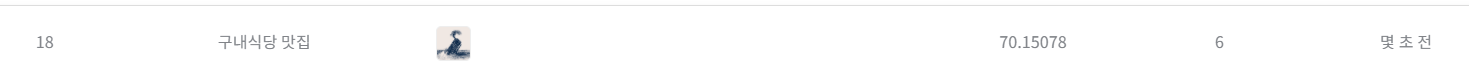